# 4 Normalizing Flows: Introduction

In [2]:
import torch
import pyro
import pyro.distributions as D
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dist_x = D.Normal(0., 1.)
exp_trans = T.ExpTransform()

In [4]:
dist_y = D.TransformedDistribution(dist_x, [exp_trans])

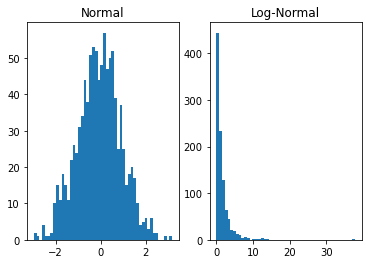

In [7]:
plt.subplot(121)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Normal')
plt.subplot(122)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()
plt.close()

In [8]:
affine = T.AffineTransform(3, 0.5)
dist_y = D.TransformedDistribution(dist_x, [affine, exp_trans])

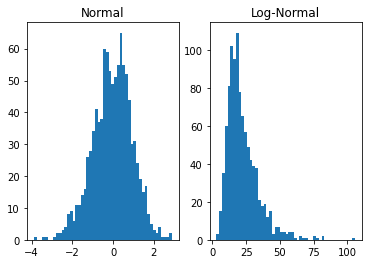

In [9]:
plt.subplot(121)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Normal')
plt.subplot(122)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()
plt.close()

In [10]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [13]:
x, y = datasets.make_circles(1000, factor=0.5, noise=0.05)
x = StandardScaler().fit_transform(x)

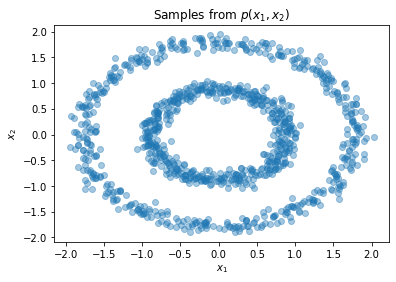

In [16]:
plt.scatter(x[:, 0], x[:, 1], alpha=0.4)
plt.title(r'Samples from $p(x_1, x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

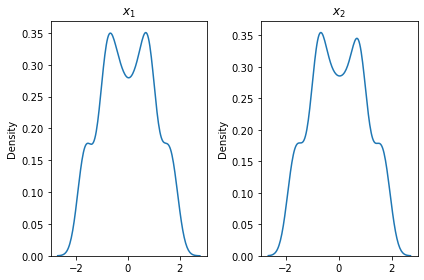

In [25]:
plt.subplot(121)
sns.kdeplot(x[:, 0])
plt.title(r'$x_1$')
plt.subplot(122)
sns.kdeplot(x[:, 1])
plt.title(r'$x_2$')
plt.tight_layout()
plt.show()

In [45]:
base = D.Normal(torch.zeros(2), torch.ones(2))
spline = T.Spline(2, 16)
flow = D.TransformedDistribution(base, [spline])

In [46]:
data = torch.from_numpy(x)
optim = torch.optim.Adam(spline.parameters(), lr=1e-2)

for step in range(1001):
    loss = - flow.log_prob(data).mean()
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    flow.clear_cache()
    
    if step % 200 == 0:
        print(f'Loss: {loss.item():.3f}')

Loss: 3.797
Loss: 1.309
Loss: 1.272
Loss: 1.264
Loss: 1.261
Loss: 1.260


In [47]:
x_flow = flow.sample((1000, ))

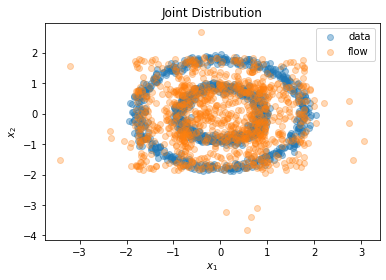

In [48]:
plt.scatter(x[:, 0], x[:, 1], alpha=0.4, label='data')
plt.scatter(x_flow[:, 0], x_flow[:, 1], alpha=0.3, label='flow')
plt.legend()
plt.title('Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

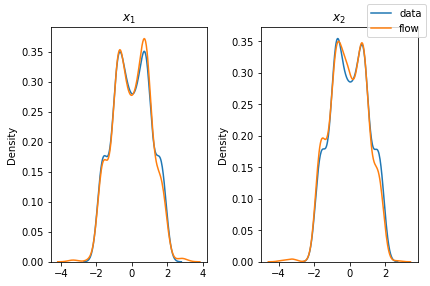

In [49]:
plt.subplot(121)
sns.kdeplot(x[:, 0])
sns.kdeplot(x_flow[:, 0])
plt.title(r'$x_1$')
plt.subplot(122)
sns.kdeplot(x[:, 1], label='data')
sns.kdeplot(x_flow[:, 1], label='flow')
plt.title(r'$x_2$')
plt.figlegend()
plt.tight_layout()
plt.show()

## Multivariate Transforms

In [50]:
base = D.Normal(torch.zeros(2), torch.ones(2))
spline = T.spline_coupling(2, count_bins=16)
flow = D.TransformedDistribution(base, [spline])

In [52]:
data = torch.from_numpy(x).type(torch.float)
optim = torch.optim.Adam(spline.parameters(), lr=1e-2)

for step in range(5001):
    loss = - flow.log_prob(data).mean()
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    flow.clear_cache()
    
    if step % 500 == 0:
        print(f'Loss: {loss.item():.3f}')

Loss: 4.405
Loss: 1.838
Loss: 1.806
Loss: 1.759
Loss: 2.385
Loss: 1.929
Loss: 1.919
Loss: 1.714
Loss: 1.687
Loss: 1.652
Loss: 1.658


In [53]:
x_flow = flow.sample((1000, ))

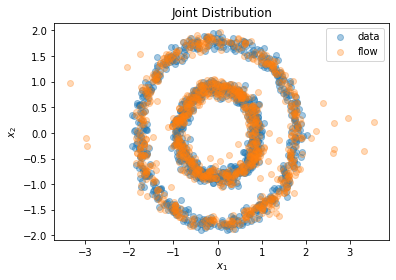

In [54]:
plt.scatter(x[:, 0], x[:, 1], alpha=0.4, label='data')
plt.scatter(x_flow[:, 0], x_flow[:, 1], alpha=0.3, label='flow')
plt.legend()
plt.title('Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

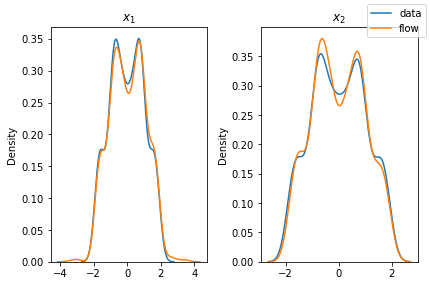

In [55]:
plt.subplot(121)
sns.kdeplot(x[:, 0])
sns.kdeplot(x_flow[:, 0])
plt.title(r'$x_1$')
plt.subplot(122)
sns.kdeplot(x[:, 1], label='data')
sns.kdeplot(x_flow[:, 1], label='flow')
plt.title(r'$x_2$')
plt.figlegend()
plt.tight_layout()
plt.show()

## Conditional vs Joint Distribution

In [59]:
base = D.Normal(torch.zeros(1), torch.ones(1))
x1_trans = T.spline(1)
dist_1 = D.TransformedDistribution(base, [x1_trans])

x2_trans = T.conditional_spline(1, 1)
dist_2 = D.ConditionalTransformedDistribution(base, [x2_trans])

In [60]:
x1 = torch.ones(1)
dist_2.condition(x1).sample()

tensor([1.0609])

In [62]:
x1 = data[:, 0][:, None]
x2 = data[:, 1][:, None]

modules = torch.nn.ModuleList([x1_trans, x2_trans])
optim = torch.optim.Adam(modules.parameters(), lr=3e-3)

for step in range(5001):
    px1 = dist_1.log_prob(x1)
    px2 = dist_2.condition(x1.detach()).log_prob(x2.detach())
    loss = - (px1 + px2).mean()
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    dist_1.clear_cache()
    dist_2.clear_cache()
    
    if step % 500 == 0:
        print(f'loss: {loss.item():.3f}')



loss: 1.888
loss: 1.800
loss: 1.807
loss: 1.768
loss: 1.752
loss: 1.742
loss: 1.744
loss: 1.761
loss: 1.721
loss: 1.719
loss: 1.716


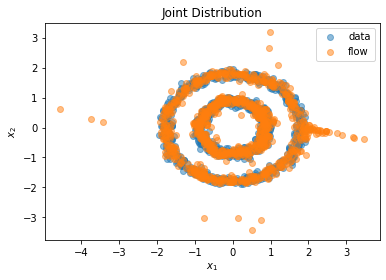

In [64]:
X = torch.cat((x1, x2), dim=-1)
x1_flow = dist_1.sample((1000, ))
x2_flow = dist_2.condition(x1_flow).sample((1000, ))
X_flow = torch.cat((x1_flow, x2_flow), dim=-1)

plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], label='flow', alpha=0.5)
plt.legend()
plt.show()

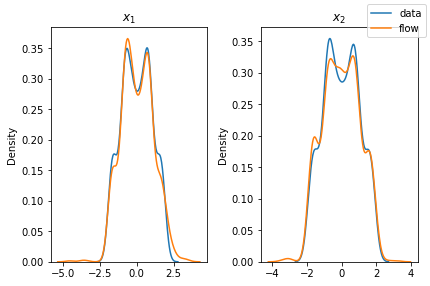

In [65]:
plt.subplot(121)
sns.kdeplot(X[:, 0])
sns.kdeplot(X_flow[:, 0])
plt.title(r'$x_1$')
plt.subplot(122)
sns.kdeplot(X[:, 1], label='data')
sns.kdeplot(X_flow[:, 1], label='flow')
plt.title(r'$x_2$')
plt.figlegend()
plt.tight_layout()
plt.show()